In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

In [2]:
data_root = "./plates"
print(os.listdir(data_root))

['test', 'train']


In [3]:
class Remove_background_and_crop:

    def __init__(self,img):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.img = img
        self.mask = img

    def crop (self):
            c_r_crop = (1.42*self.r00/2)
            self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
            crop = self.img
            cv2.imwrite(image_folder,crop)
            h,w = self.img.shape[:2]
            c = min(h,w)
            for i in range (5,int(c/3),5):
                    crop_img = self.img[i:h-i,i:w-i]
                    cv2.imwrite(image_folder[:-4] +  '_Crop_' + str(i) + '.jpg',crop_img)
            image1 = self.img[0:int(h//2),0:int(w//2)]
            #Делим изображение на 4 части
            cv2.imwrite(image_folder[:-4] +  'image1' + '.jpg',image1)
            image2 = self.img[int(h//2):h,int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image2' + '.jpg',image2)
            image3 = self.img[int(h//2):h,0:int(w//2)]
            cv2.imwrite(image_folder[:-4] +  'image3' + '.jpg',image3)
            image4 = self.img[0:int(h//2),int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image4' + '.jpg',image4)

    def crop_test (self):
        c_r_crop = (1.42*self.r00/2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(image_folder,self.img)

    def find_circle(self):
        output = self.img.copy()
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10,param1=10,param2=5,minRadius=40,maxRadius=250)

        if circles is not None:
            #print('Координаты центра:',self.x00,self.y00)
            circles = np.round(circles[0, :]).astype("int")
            #print('Возможные координаты центра и радиусы:')
            #print(circles)

            for x, y, r in circles:
                if ((self.x00-15)<x<(self.x00+15)) and ((self.y00-15)<y<(self.y00+15)):
                    if r > self.r00:
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r
                        #print('Найдено совпадение:',x,y,r)

            if self.r00==0:
                #print('Тарелка не найдена','\n')
                ret,thresh = cv2.threshold(self.mask,235,255,0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)
            #print('Выбранные координаты центра:',self.x00,self.y00,self.r00)

    def findCoordinates(self):
        ret,thresh = cv2.threshold(self.mask,235,255,0)
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])

#    def findCenter(self):
#        c_r_crop = 124
#        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]

    def remove_background(self):
        mainRectSize = .08
        fgSize = .01
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255]
        self.img = masked
        self.mask = mask_result

for image_index in range (20):
    print ("Complete dirty: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = 'plates/train/dirty/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")
# print("dirty")

for image_index in range (20):
    print ("Complete cleaned: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = 'plates/train/cleaned/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")
# print("cleaned")

for image_index in range (744):
    print ("Complete test: ","{0:04}".format(image_index),"/0743", end="\r")
    image_folder = 'plates/test/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop_test()
print ("\n\r", end="")
# print("test")

Complete dirty:  0019 /0019
Complete cleaned:  0019 /0019
Complete test:  0743 /0743


In [4]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 275/275 [00:00<00:00, 1244.89it/s]


In [5]:
!ls train

cleaned
dirty


In [6]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

C:\Users\ruslan\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
len(train_dataloader), len(train_dataset)

(29, 452)

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [9]:
# plt.imshow(X_batch[0].permute(1, 2, 0).numpy());

In [10]:
def show_input(input_tensor, title='', num_batch=0, num_elem_batch=0):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(str(num_batch) + "." + str(num_elem_batch) + ") " + title)
    plt.show()
    plt.pause(0.001)

def show_input_all(dataloader):
    it = iter(dataloader)
    for i in range(len(dataloader)):
        X_batch, y_batch = next(it)
        num_elem_batch = 0
        for x_item, y_item in zip(X_batch, y_batch):
            show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
            num_elem_batch += 1

In [ ]:
show_input_all(train_dataloader)

In [ ]:
show_input_all(val_dataloader)

In [23]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

    return model

In [18]:
# model = models.resnet152(pretrained=True)
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

True


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=30)

In [20]:
losses = {}
accuracies = {}

losses['train'], accuracies['train'] = train_loss_history, [elem.item() for elem in train_accuracy_history]
losses['val'], accuracies['val'] = val_loss_history, [elem.item() for elem in val_accuracy_history]

[0.5933156876728453, 0.6195491017966435, 0.5977873432225195, 0.6109593397584455, 0.597944228813566, 0.622489813072928, 0.5966376353954447, 0.6059150490267523, 0.5918256845967523, 0.5927623387040764, 0.6110313195606758, 0.6020590395763002, 0.6079848716998922, 0.6012996363228765]
[0.4682981272538503, 0.602764164408048, 0.6043335199356079, 0.608172337214152, 0.621586854259173, 0.6049201041460037, 0.6172956426938375, 0.6412463784217834, 0.620049407084783, 0.5786057114601135, 0.6272156685590744, 0.6073846220970154, 0.624857559800148, 0.5918387224276861]


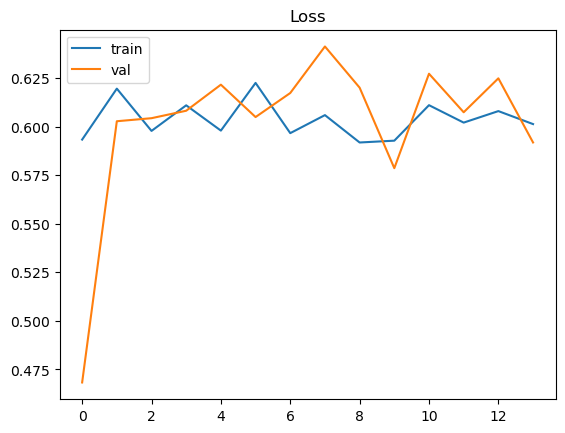

In [21]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Loss')
print(losses['train'])
print(losses['val'])

[0.7112069129943848, 0.6767241358757019, 0.6896551847457886, 0.6831896305084229, 0.6961206793785095, 0.6767241358757019, 0.7413793206214905, 0.7133620381355286, 0.7176724076271057, 0.7219827771186829, 0.6853448152542114, 0.7068965435028076, 0.7025862336158752, 0.7112069129943848]
[0.84375, 0.669507622718811, 0.7196969985961914, 0.6941288709640503, 0.6950757503509521, 0.6856061220169067, 0.6278409361839294, 0.5965909361839294, 0.6685606241226196, 0.7462121844291687, 0.6837121844291687, 0.7149621844291687, 0.6732954978942871, 0.7357954978942871]


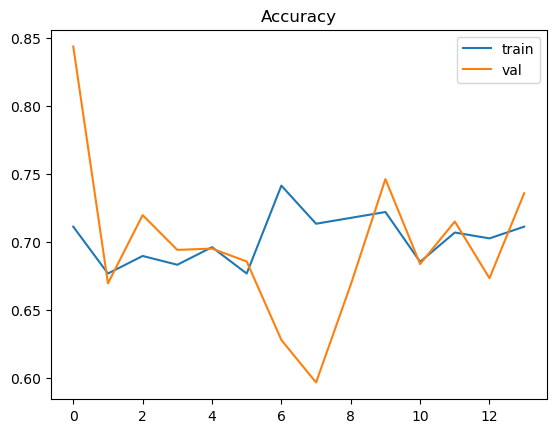

In [22]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Accuracy')
print(accuracies['train'])
print(accuracies['val'])

In [24]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test\\unknown'

In [25]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [26]:
df = pd.DataFrame
#Итерируемся по Crop'ам test датасета
for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths('test', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #Новый даталоадер с путями до изображений

    model.eval() #Переводим модель в состояние eval
    test_predictions = []  #Создаем пустой список предсказания
    test_img_paths = [] #Пути до изображения
    for inputs, labels, paths in tqdm(test_dataloader): #Цикл по test_dataloader inputs - батч с изображением, lable - тут none, paths - пути до изображения
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs) # Считаем предикшены
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()) #С помощью torch.nn.functional.softmax получаем вероятности, для первого класса [:,1], пеереводим тензор в .data, на .cpu(), в numpy
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)


    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace(test_dir + "\\unknown\\", "")
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)

    try : df = df.merge(submission_df, how='inner', on='id') #Объединяем в один датафрейм
    except BaseException: # Для первой итерации
        df = submission_df
    #submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
    #submission_df.to_csv('submission_predict_{0}.csv'.format(i))
df.head(8)

100%|██████████| 47/47 [00:29<00:00,  1.62it/s]


,label
id,
0000,0.477654
0001,0.540665
0002,0.761256
0003,0.685739
0004,0.585608
0005,0.557720
0006,0.600425
0007,0.542130


In [27]:
df['mean'] = df.mean(axis=1)
df.drop(df.columns[:-1], axis='columns', inplace=True)
df['label'] = df['mean'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head(10)

,label
id,
0000,cleaned
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [28]:
df.to_csv('submission.csv')

In [ ]:
# !rm -rf train val test plates